<a href="https://www.kaggle.com/code/likithagedipudi/vesaki-multimodal-virtual-try-on-studio-v1?scriptVersionId=286270389" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Vesaki - Multimodal Virtual Try‑On Studio + Lookbook (Gemini 3 Pro)

## Links
- GitHub repo: https://github.com/Likitha-Gedipudi/Vesaki-v2
- YouTube demo: https://www.youtube.com/watch?v=L_qkEkCxda8
- Live app: https://ai.studio/apps/drive/1U_ptzZW_61LOMQ5XyQ6d6eV9ghAQBW7D


This notebook mirrors the core logic in `services/geminiService.ts` using the official **Google Gen AI Python SDK** (`google-genai`). It lets you:

- Run **text-based** virtual try-on edits (uses the repo's prompt structure + the *Semantic Anatomist* prompt refinement)
- (Optional) Generate a **360° video** with **Veo**
- Analyze a clothing item image into structured JSON
- Generate outfit suggestions from a wardrobe list

Notes:
- The web app uses `@google/genai` (JS). This notebook uses `google-genai` (Python).
- You need a Gemini API key. Set `GEMINI_API_KEY` (recommended) or `API_KEY` in your environment.
- Model access can vary by account/project. If a model returns permission errors, try swapping to another available model.

In [1]:
# If you're in a fresh environment, install dependencies.\n
# (In many Jupyter setups, restarting the kernel after installation helps.)\n
%pip -q install google-genai pillow pydantic

Note: you may need to restart the kernel to use updated packages.


In [2]:
import base64
import json
import mimetypes
import os
import time
from dataclasses import dataclass
from pathlib import Path

from pydantic import BaseModel
from google import genai
from google.genai import types

# Access Kaggle Secret
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

# Get the API key from Kaggle Secrets
# Use the exact name you gave it when you created the secret
API_KEY = user_secrets.get_secret("GEMINI_API_KEY")  # or whatever you named it

client = genai.Client(api_key=API_KEY)
print("Client initialized")

Client initialized


## Helpers: load images + convert to GenAI parts

In [3]:
def read_image_bytes(path: str | Path) -> tuple[bytes, str]:
    path = Path(path)
    data = path.read_bytes()
    mime, _ = mimetypes.guess_type(str(path))
    mime = mime or "image/jpeg"
    return data, mime

def part_from_image_file(path: str | Path) -> types.Part:
    data, mime = read_image_bytes(path)
    return types.Part.from_bytes(data=data, mime_type=mime)

def data_url_from_bytes(data: bytes, mime_type: str) -> str:
    b64 = base64.b64encode(data).decode("utf-8")
    return f"data:{mime_type};base64,{b64}"

def first_image_from_response(resp):
    # The SDK exposes convenience properties like resp.parts on some responses.
    # This handles a couple formats and returns a PIL Image when possible.
    parts = []
    if getattr(resp, "parts", None):
        parts = resp.parts
    elif getattr(resp, "candidates", None):
        cand = resp.candidates[0]
        if cand.content and cand.content.parts:
            parts = cand.content.parts

    for p in parts:
        if getattr(p, "inline_data", None):
            try:
                return p.as_image()
            except Exception:
                pass
    return None

## Semantic Anatomist (prompt refinement)\n
This replicates the `refinePromptWithSegmentation()` logic from `services/geminiService.ts` (logic layer with `gemini-2.5-flash`).

In [4]:
LOGIC_MODEL = "gemini-2.5-flash"
IMAGE_MODEL = "gemini-2.5-flash-image"

SEMANTIC_ANATOMIST_SYSTEM = (
    "You are an Expert Fashion Image Prompt Engineer. "
    "Your goal is to prevent 'Semantic Bleed' where a request for a Top accidentally colors the Pants or Skirt."
)

def refine_prompt_with_segmentation(user_prompt: str) -> str:
    analysis_prompt = f'''
User Request: "{user_prompt}"

Task:
1. Identify the Target Zone (e.g., Upper Body, Lower Body, Feet, Head).
2. Identify the Preservation Zone (what must NOT change).
3. Write specific negative constraints for "Monolithic Garments" (Dresses, Jumpsuits, Coats).

If the user asks for a TOP (shirt, blouse, jacket):
- explicitly instruct to STOP at the waist.
- explicitly instruct that the bottom half must remain distinct.

Return a concise, powerful prompt addendum starting with "IMPORTANT VISUAL RULES:".
'''

    try:
        resp = client.models.generate_content(
            model=LOGIC_MODEL,
            contents=[
                types.Content(role="user", parts=[
                    types.Part(text=SEMANTIC_ANATOMIST_SYSTEM),
                    types.Part(text=analysis_prompt),
                ])
            ],
        )
        return resp.text or ""
    except Exception as e:
        print("Prompt refinement failed; using raw prompt. Error:", e)
        return ""


## Virtual try-on (text edit)\n
This mirrors the text-edit path in `generateFashionFromPrompt()` from the repo (prompt structure + identity lock / negative constraints).

In [5]:
PROHIBITED_KEYWORDS = {
    'lingerie', 'underwear', 'undergarment', 'bra', 'panty', 'panties',
    'thong', 'bikini', 'swimsuit', 'swimwear', 'boxers', 'briefs', 'knickers'
}

def contains_prohibited(prompt: str) -> bool:
    p = prompt.lower()
    return any(k in p for k in PROHIBITED_KEYWORDS)

def generate_fashion_from_prompt(
    base_image_path: str | Path,
    prompt_text: str,
    image_model: str = IMAGE_MODEL,
):
    if contains_prohibited(prompt_text):
        raise ValueError("Blocked: lingerie/undergarment requests are refused (privacy guardrail).")

    parts: list[types.Part] = []
    parts.append(part_from_image_file(base_image_path))

    segmentation_rules = ""
    if prompt_text.strip():
        segmentation_rules = refine_prompt_with_segmentation(prompt_text)

    # TEXT EDITING MODE
    final_prompt = f'''
ROLE: Professional Photo Editor and Stylist.

TASK: Edit the clothing of the person in the input image based on the text description below.

USER REQUEST: "{prompt_text}"

{segmentation_rules}

EXECUTION GUIDELINES:
1. IDENTITY LOCK: Face, hair, features, body pose must remain identical; background identical; only targeted clothing changes.
2. SMART REPLACEMENT: Add jackets over existing tops; adding accessories should not change clothing; pants edits keep top unchanged.
3. PHOTOREALISM: Material must look real; lighting must match original.

NEGATIVE CONSTRAINTS:
- No cartoons. No distorted faces. No extra limbs.
- Do not change items not targeted by the request.

OUTPUT: A single, high-quality, photorealistic JPEG image.
'''

    parts.append(types.Part(text=final_prompt))

    resp = client.models.generate_content(
        model=image_model,
        contents=[types.Content(role="user", parts=parts)],
        config=types.GenerateContentConfig(
            # Ask explicitly for IMAGE output.
            response_modalities=["IMAGE"],
        ),
    )

    img = first_image_from_response(resp)
    if img is None:
        raise RuntimeError("No image returned. Check model availability/permissions or try a different prompt.")
    return img


## Try it\n\n
1. Put an image on disk (a person photo).\n\n
2. Run the cell to generate a new look.

ORIGINAL IMAGE:


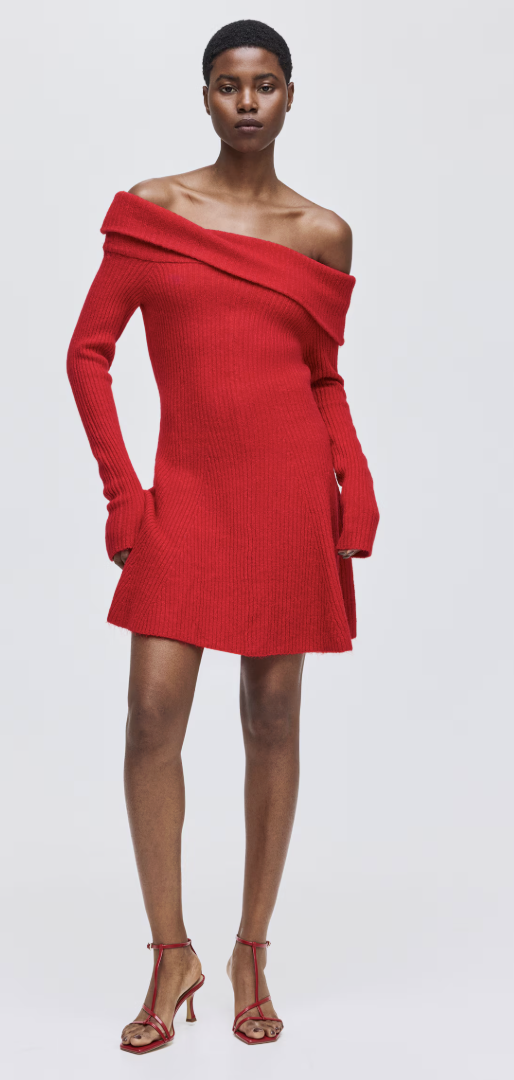


GENERATED IMAGE:


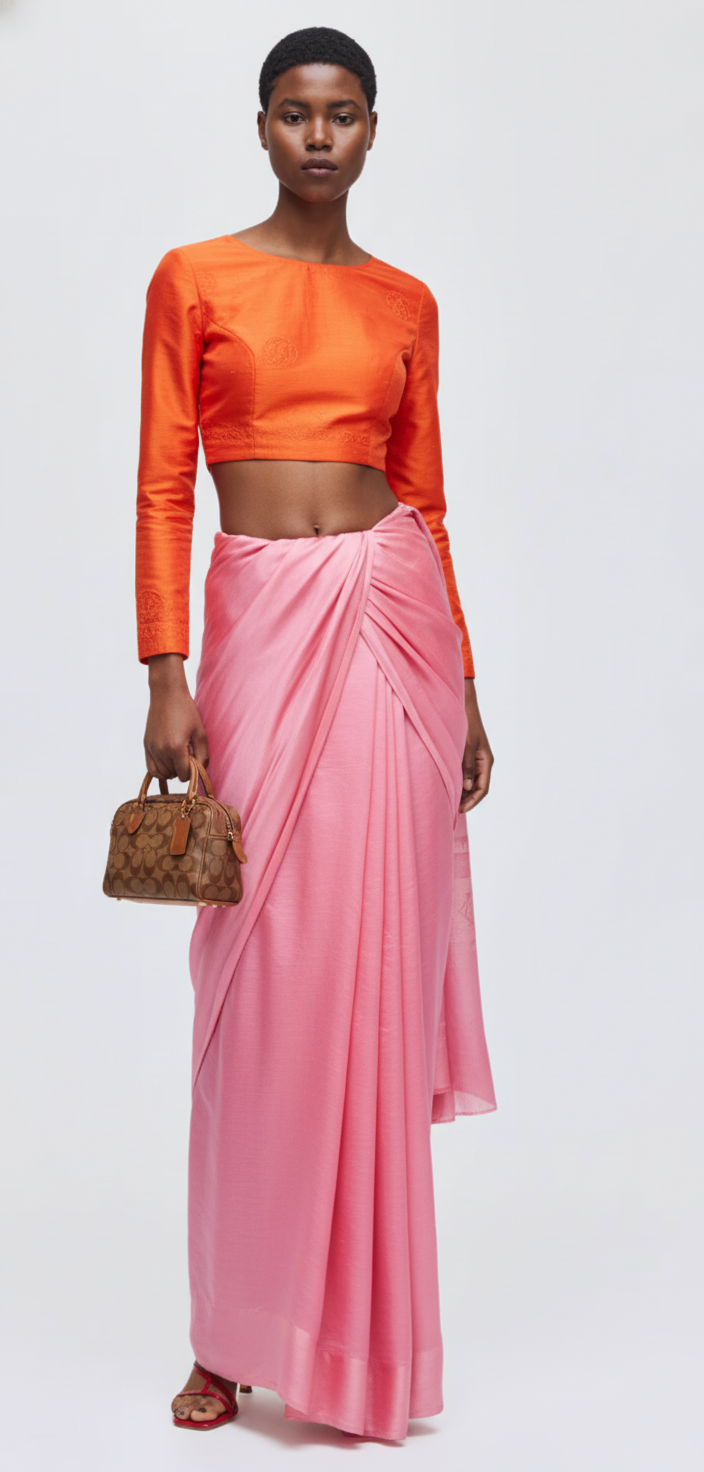


Saved to /kaggle/working/generated_outfit.png

ANALYZING CHANGES:
Here's a detailed analysis of the changes between the two images:

**1. What clothing items were changed?**

*   **Original (Image 1):** The model is wearing a single piece, a red off-shoulder, long-sleeve, ribbed knit mini dress with a flared A-line skirt.
*   **Generated (Image 2):**
    *   The red knit dress was **completely replaced**.
    *   The upper body is now covered by a long-sleeve, crew-neck, cropped orange blouse/top, exposing the midriff.
    *   The lower body is covered by a floor-length, draped pink garment, resembling a saree or a very flowy, high-waisted skirt.
    *   A small, structured brown handbag with a monogram pattern (looks like Coach) was **added** and is held in the model's left hand.
    *   The red strappy high-heeled sandals **remained exactly the same**.

**2. What colors changed?**

*   **Original (Image 1):** The predominant clothing color is a bright, deep red (dress and shoes).
* 

In [6]:
from IPython.display import display
from PIL import Image
import io

BASE_IMAGE_PATH = "/kaggle/input/vesaki-demo/Model 1.png"
PROMPT = "pink silk saree with round-neck designer orange blouse and coach bag."

# Load and display original
print("=" * 50)
print("ORIGINAL IMAGE:")
print("=" * 50)
original = Image.open(BASE_IMAGE_PATH)
display(original)

# Generate new look
print("\n" + "=" * 50)
print("GENERATED IMAGE:")
print("=" * 50)
img = generate_fashion_from_prompt(
    base_image_path=BASE_IMAGE_PATH,
    prompt_text=PROMPT,
)

# Convert GenAI Image to PIL Image
if hasattr(img, 'image_bytes'):
    pil_img = Image.open(io.BytesIO(img.image_bytes))
    display(pil_img)
    
    # Save for later use
    output_path = "/kaggle/working/generated_outfit.png"
    pil_img.save(output_path)
    print(f"\nSaved to {output_path}")
else:
    pil_img = img
    display(pil_img)

# Now analyze the differences
print("\n" + "=" * 50)
print("ANALYZING CHANGES:")
print("=" * 50)

# Create comparison prompt
comparison_prompt = """
Compare these two images and identify exactly what changed:

Image 1: Original
Image 2: Generated after editing

Please provide a detailed analysis:
1. What clothing items were changed?
2. What colors changed?
3. What stayed the same?
4. Overall quality of the transformation
"""

# Use Gemini to compare
resp = client.models.generate_content(
    model=LOGIC_MODEL,
    contents=[types.Content(role="user", parts=[
        part_from_image_file(BASE_IMAGE_PATH),
        types.Part.from_bytes(data=img.image_bytes, mime_type=img.mime_type) if hasattr(img, 'image_bytes') else part_from_image_file(output_path),
        types.Part(text=comparison_prompt),
    ])],
)

print(resp.text)

## Clothing item analyzer (image → structured JSON)\n
This mirrors `analyzeClothingImage()` from `services/geminiService.ts`, using `response_mime_type=application/json` + a schema.

In [7]:
class ClothingItemExtract(BaseModel):
    category: str | None = None
    description: str | None = None
    color: str | None = None
    brand: str | None = None
    tags: list[str] | None = None

def analyze_clothing_image(image_path: str | Path) -> ClothingItemExtract:
    img_part = part_from_image_file(image_path)
    resp = client.models.generate_content(
        model=LOGIC_MODEL,
        contents=[types.Content(role="user", parts=[
            img_part,
            types.Part(text="Analyze this clothing item image. Extract details into JSON."),
        ])],
        config=types.GenerateContentConfig(
            response_mime_type="application/json",
            response_schema=ClothingItemExtract,
        ),
    )
    # Many SDK responses expose .parsed when response_schema is set.
    if getattr(resp, "parsed", None) is not None:
        return resp.parsed
    # Fallback
    return ClothingItemExtract.model_validate_json(resp.text or "{}")

# Example:
# analyze_clothing_image("/path/to/clothing_item.jpg")

## Outfit suggestions (wardrobe → JSON)\n
This mirrors `generateOutfitSuggestions()` from the repo.

In [8]:
class OutfitSuggestion(BaseModel):
    name: str
    itemIds: list[str]
    reasoning: str

def generate_outfit_suggestions(wardrobe: list[dict], user_profile: dict, occasion: str) -> list[OutfitSuggestion]:
    wardrobe_list = "\n".join(
        f"- ID: {i['id']}, {i.get('color','')} {i.get('category','')} ({i.get('description','')})"
        for i in wardrobe
    )

    prompt = f'''
Role: Personal Stylist.
User Profile: Name: {user_profile.get('name','')}, Style: {', '.join(user_profile.get('stylePreferences', []))}.
Occasion: {occasion}.

Available Wardrobe:
{wardrobe_list}

Task: Create up to 3 outfit combinations from the available wardrobe suitable for the occasion.
Return JSON.
'''

    resp = client.models.generate_content(
        model=LOGIC_MODEL,
        contents=prompt,
        config=types.GenerateContentConfig(
            response_mime_type="application/json",
            # Explicit ARRAY schema (matches the TS app's `Type.ARRAY` usage).
            response_schema={
                'type': 'ARRAY',
                'items': {
                    'type': 'OBJECT',
                    'properties': {
                        'name': {'type': 'STRING'},
                        'itemIds': {'type': 'ARRAY', 'items': {'type': 'STRING'}},
                        'reasoning': {'type': 'STRING'},
                    },
                    'required': ['name', 'itemIds', 'reasoning'],
                },
            },
        ),
    )

    if getattr(resp, "parsed", None) is not None:
        return resp.parsed

    raw = json.loads(resp.text or "[]")
    return [OutfitSuggestion.model_validate(x) for x in raw]

# Example input you can tweak:
wardrobe = [
    {"id": "1", "category": "Top", "description": "white tee", "color": "white"},
    {"id": "2", "category": "Bottom", "description": "blue jeans", "color": "blue"},
    {"id": "3", "category": "Shoes", "description": "white sneakers", "color": "white"},
]
profile = {"name": "You", "stylePreferences": ["minimal", "streetwear"]}

generate_outfit_suggestions(wardrobe, profile, occasion="Casual brunch")

[{'name': 'Minimal Brunch Streetwear',
  'itemIds': ['1', '2', '3'],
  'reasoning': 'This outfit combines a classic white tee, comfortable blue jeans, and clean white sneakers. It perfectly aligns with a minimal and streetwear aesthetic, offering a relaxed yet stylish look ideal for a casual brunch.'}]

## (Optional) 360° video (Veo)\n
This mirrors `generate360Video()` from the repo. Video generation is often gated/preview and may require additional enablement.\n
\n
If you hit permission errors, skip this section or try a different `veo-*` model available to your account.

In [9]:
def generate_360_video_from_image(image_path: str | Path, model: str = 'veo-3.1-fast-generate-preview'):
    image = types.Image.from_file(str(image_path))
    operation = client.models.generate_videos(
        model=model,
        prompt=(
            'Cinematic 360 degree rotating camera orbit shot of this person, '
            'showing the outfit from all angles, studio fashion lighting, 4k, smooth motion, photorealistic.'
        ),
        image=image,
        config=types.GenerateVideosConfig(
            number_of_videos=1,
            duration_seconds=5,
            enhance_prompt=True,
        ),
    )

    while not operation.done:
        time.sleep(10)
        operation = client.operations.get(operation)

    video = operation.response.generated_videos[0].video
    return video

# Example:
# video = generate_360_video_from_image('/path/to/generated_or_source_image.jpg')
# video.show()